# Stage 2020-2021

# Active Learning appliqué à l'OPV (Photovoltaïques organiques) :

## 1- Importation des bibliothèques nécessaires :

### a) Bibliothèques usuelles

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

### b) Bibliothèques du Machine Learning

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### c) Bibliothèques de l'Active Learning

In [3]:
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.uncertainty import uncertainty_sampling
from modAL.disagreement import max_std_sampling

## 2- Importation des données 

In [4]:
# loading dataset :
opv =  pd.read_csv("C:/Users/salma/OneDrive/Bureau/Stage 2020-2021/Machine Learning/Publications/OPV_publication/Data/table1_1.csv")
opv

,exp,don_con,total_con,spin_s,addive,pce,nb_dev
0,1,10,20,3000,2,0.05000,14
1,2,10,25,1000,8,3.24000,10
2,3,10,10,600,0,0.01600,14
3,4,10,15,2000,12,0.00040,10
4,5,25,20,600,12,7.14000,8
5,6,25,15,1000,2,3.22000,8
6,7,25,10,3000,8,0.00033,14
7,8,25,25,2000,0,7.21000,11
8,9,40,10,1000,12,1.85000,3
9,10,40,20,2000,8,6.16000,12


**a)** On sépare les facteurs et la variable cible.

In [5]:
X = opv[['don_con','total_con','spin_s']]
Y = opv['pce']

on transforme le dataframe en une matrice (numpy)

In [6]:
X_raw=X.to_numpy()
Y_raw=Y.to_numpy()

**b)** On choisit les premières instances étiquetées  

In [7]:
racine = 0
n_initial = X_raw.shape[0] 
size = 3
random.seed(racine)
lab_indices1 =  random.sample(range(n_initial), size)
print(lab_indices1)

[13, 6, 12]


In [8]:
# Pour mélangér les données d'une liste : exemple
#random.shuffle(training_indices)
#print(training_indices)

In [9]:
#On mélange nos données
random.shuffle(X_raw)
print(X_raw)

[[  10   20 3000]
 [  10   20 3000]
 [  10   10  600]
 [  10   25 1000]
 [  25   20  600]
 [  10   10  600]
 [  10   15 2000]
 [  25   20  600]
 [  25   10 3000]
 [  25   25 2000]
 [  40   10 1000]
 [  25   20  600]
 [  10   20 3000]
 [  25   10 3000]
 [  55   20 1000]]


In [10]:
# Les données étiquetées.
X_lab = X_raw[lab_indices1]
Y_lab = Y_raw[lab_indices1] 

In [11]:
# Les données non-étiquetées.
X_unlab = np.delete(X_raw, lab_indices1, axis=0) 
Y_unlab = np.delete(Y_raw, lab_indices1, axis=0)

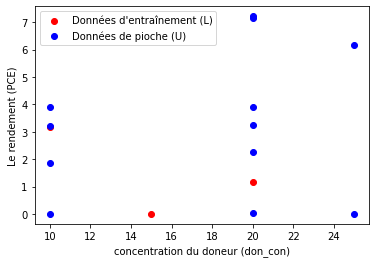

In [12]:
plt.scatter(X_lab[:,1], Y_lab, color = 'r', label="Données d'entraînement (L)")
plt.scatter(X_unlab[:,1], Y_unlab, color='b', label="Données de pioche (U)")
plt.xlabel('concentration du doneur (don_con)')
plt.ylabel('Le rendement (PCE)')
plt.legend()

## 3- L'apprenant  

### 3.1- Avec 3 apprenants en utilisant le committee

Pour créer un objet ActiveLearner, on doit fournir deux choses : un objet estimateur scikit-learn et une fonction de stratégie d'interrogation (cette dernière est optionnelle, la stratégie par défaut est l'échantillonnage à incertitude maximale). En ce qui concerne les stratégies d'interrogation, on peut trouver des modules intégrés dans modAL.uncertainty, mais on peut aussi implémenter les notres.

In [13]:
learner_list = [ActiveLearner(
                        estimator=RandomForestRegressor(random_state = idx+racine),
                        X_training=X_lab, y_training=Y_lab,
                )
                for idx in range(3)]

In [14]:
learner_list

C:\Users\salma\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


[ActiveLearner(X_training=array([[  25,   10, 3000],
        [  10,   15, 2000],
        [  10,   20, 3000]], dtype=int64),
               bootstrap_init=None,
               estimator=RandomForestRegressor(random_state=0),
               y_training=array([3.18e+00, 3.30e-04, 1.16e+00])),
 ActiveLearner(X_training=array([[  25,   10, 3000],
        [  10,   15, 2000],
        [  10,   20, 3000]], dtype=int64),
               bootstrap_init=None,
               estimator=RandomForestRegressor(random_state=1),
               y_training=array([3.18e+00, 3.30e-04, 1.16e+00])),
 ActiveLearner(X_training=array([[  25,   10, 3000],
        [  10,   15, 2000],
        [  10,   20, 3000]], dtype=int64),
               bootstrap_init=None,
               estimator=RandomForestRegressor(random_state=2),
               y_training=array([3.18e+00, 3.30e-04, 1.16e+00]))]

L'une des stratégies d'apprentissage actif les plus populaires est **la requête par comité** , où nous conservons plusieurs hypothèses (c'est-à-dire des classificateurs entraînés) sur les données, et nous sélectionnons nos requêtes en mesurant le désaccord des hypothèses. En modAL, ce modèle est implémenté dans la classe **Comité**.

Pour créer un objet Comité, vous devez fournir deux choses : une liste d'objets ActiveLearner et une fonction de stratégie de requête . (Une liste d' estimateurs scikit-learn ne suffira pas, car chaque apprenant doit garder une trace des exemples de formation qu'il a vus.) Par exemple, vous pouvez procéder comme suit.

In [15]:
# Le Committee
committee1 = CommitteeRegressor(
    learner_list=learner_list,
    query_strategy=max_std_sampling
)

In [16]:
# Prédiction de chaque apprenant
for learner_idx, learner in enumerate(committee1):
    print("prédiction de l'apprenant no %d : \n"  % (learner_idx + 1) , learner.predict(X_raw))

prédiction de l'apprenant no 1 : 
 [1.0952759 1.0952759 1.2811782 0.681165  1.241532  1.2811782 0.6770409
 1.241532  2.1976726 1.241532  1.9227221 1.241532  1.0952759 2.1976726
 1.241532 ]
prédiction de l'apprenant no 2 : 
 [1.1648561 1.1648561 1.3219551 0.857732  1.7416759 1.3219551 0.7178178
 1.7416759 2.4086528 1.7416759 2.2638825 1.7416759 1.1648561 2.4086528
 1.7416759]
prédiction de l'apprenant no 3 : 
 [1.2628627 1.2628627 1.2089815 0.6897683 1.2097353 1.2089815 0.5412508
 1.2097353 2.2788495 1.2097353 1.786932  1.2097353 1.2628627 2.2788495
 1.2097353]


In [17]:
# Isolate the data we'll need for plotting.
predictions_init = committee1.predict(X_raw)

In [18]:
predictions_init

array([1.17433157, 1.17433157, 1.27070493, 0.74288843, 1.39764773,
       1.27070493, 0.64536983, 1.39764773, 2.2950583 , 1.39764773,
       1.99117887, 1.39764773, 1.17433157, 2.2950583 , 1.39764773])

In [19]:
def erreur(pred, Y) :
    n = Y.shape[0] 
    err = 1/(2*n)*np.sum((Y-pred)**2) 
    return err

In [20]:
err_init = erreur(predictions_init, Y)

In [21]:
score_init = r2_score(predictions_init,Y)
print("score initiale", score_init)

score initiale -34.966999700859866


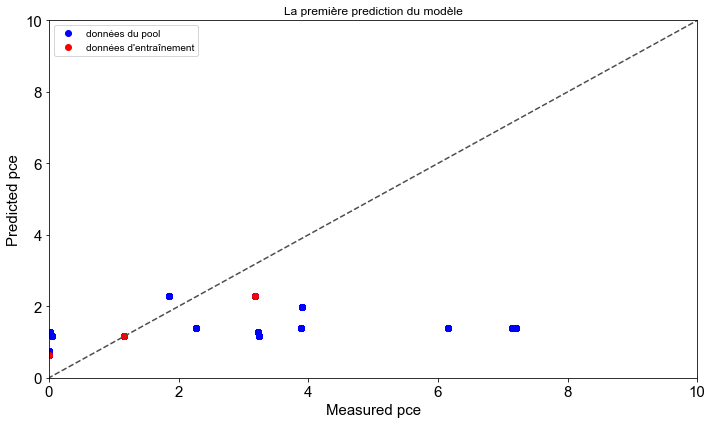

In [22]:
fig, ax = plt.subplots(1, 1, clear = True, num = 'Predicted vs Measured pce', figsize=(10, 6))  
prediction = committee1.predict(X)
for label, data in opv.groupby('exp'):   
    p1, = ax.plot(Y, predictions_init, 'bo') 
    p2, = ax.plot(Y_lab, predictions_init[lab_indices1], 'ro')
plt.title('La première prediction du modèle')    
plt.plot([-1, 10], [-1, 10], ls = "--", c = ".3")  
plt.autoscale(enable = False)                    
plt.xlim(0,10)                             
plt.ylim(0,10)
plt.legend([p1,p2],["données du pool","données d'entraînement"], loc='upper left')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
font = {'size': 15}
ax.set_xlabel(r'Measured pce', font)
ax.set_ylabel(r'Predicted pce', font)

plt.style.use('seaborn')                 

plt.tight_layout()                        
plt.show()         

La méthode **`.query(X)`** méthode appelle simplement la fonction de stratégie de requête que vous avez spécifiée lors de l'initialisation de l'ActiveLearner.

La formation est également disponible avec bootstrap en passant bootstrap=Truepour learner.teach()ou learner.fit(). Dans ce cas, un ensemble aléatoire est échantillonné avec remise à partir des données d'apprentissage disponibles (ou des données fournies dans le cas de .fit()), qui sont utilisées pour former l'estimateur. L'amorçage est surtout utile lors de la création de modèles d'ensemble avec bagging, par exemple dans le cadre d'une requête par comité .

[4]
[13, 6, 12, 4]
[2]
[13, 6, 12, 4, 2]
[6]
[13, 6, 12, 4, 2, 6]
[0]
[13, 6, 12, 4, 2, 6, 0]
[5]
[13, 6, 12, 4, 2, 6, 0, 5]
[6]
[13, 6, 12, 4, 2, 6, 0, 5, 6]


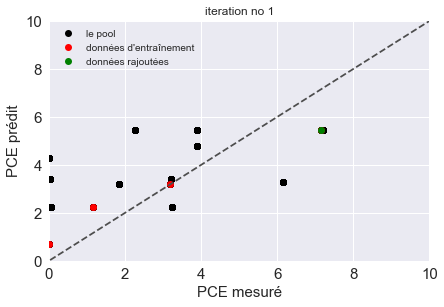

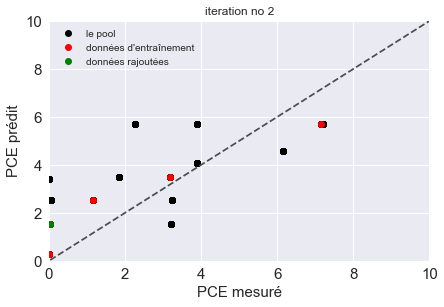

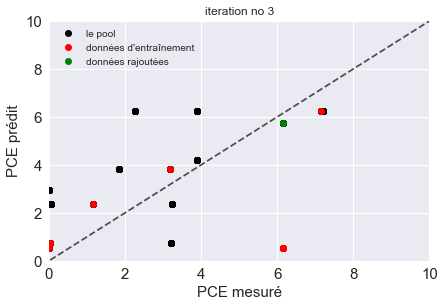

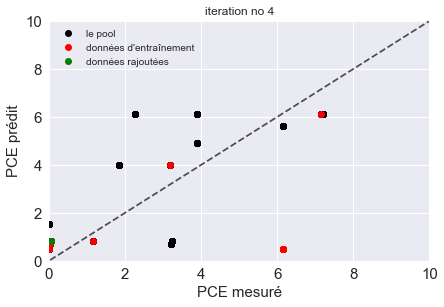

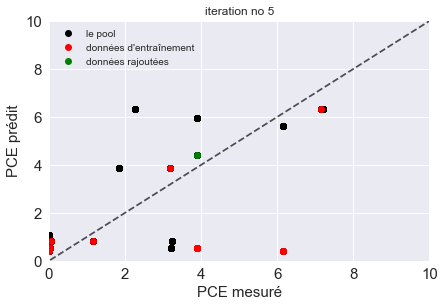

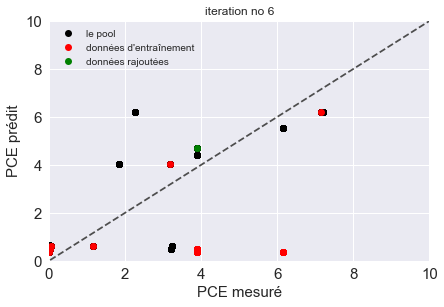

In [23]:
#Active regression 
erreur_model = [err_init]
score_model = [score_init]
n_queries= 6
#performance_history = [unqueried_score]
# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(n_queries):
    query_index, query_instance = committee1.query(X_unlab)
    print(query_index)
# Teach our ActiveLearner model the record it has requested.
    X_new, Y_new = X_unlab[query_index].reshape(1, -1), Y_unlab[query_index].reshape(1, )
    committee1.teach(X=X_new, y=Y_new)
    pred_new = committee1.predict(X_new)
    # Remove the queried instance from the unlabeled pool.
    X_lab, Y_lab= np.vstack([X_lab, query_instance]), np.hstack([Y_lab, Y_unlab[query_index]])
    X_unlab, Y_unlab = np.delete(X_unlab, query_index, axis=0), np.delete(Y_unlab, query_index)
    lab_indices1.extend(query_index)
    print(lab_indices1)
    predictions = committee1.predict(X)
    #print(predictions)
    err = erreur(predictions, Y)
    erreur_model.append(err)
    sc = r2_score(Y, predictions)
    score_model.append(sc)
    plt.figure(figsize=(15, 15))
    plt.subplot(3,2,index+1)
    for label, data in opv.groupby('exp'): 
        p1, = plt.plot(Y, predictions, 'ko')
        #plt.plot(Y_unlab[query_index], )
        p2, = plt.plot(Y_lab, predictions[lab_indices1], 'ro')
        p3, = plt.plot(Y_new, pred_new, 'go')
        plt.title('iteration no %d' % (index+1))    
    plt.plot([-1, 10], [-1, 10], ls = "--", c = ".3")  
    plt.autoscale(enable = False)                    
    plt.legend([p1,p2,p3],["le pool","données d'entraînement","données rajoutées"], loc='upper left')
    plt.xlim(0,10)                             
    plt.ylim(0,10)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    font = {'size': 15}
    plt.xlabel('PCE mesuré', font)
    plt.ylabel('PCE prédit', font)

No handles with labels found to put in legend.


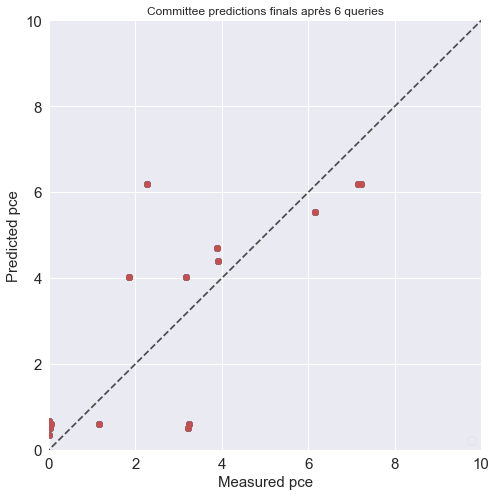

In [24]:
# visualizing the Committee's predictions

fig, ax1 = plt.subplots(1, 1, clear = True, num = 'Predicted vs Measured pce', figsize=(7, 7))  
prediction = committee1.predict(X)
for label, data in opv.groupby('exp'):   
    plt.plot(Y, prediction, 'o') 
plt.title('Committee predictions finals après %d queries' % n_queries)
plt.legend(loc='lower right', frameon = True)     
plt.plot([-1, 10], [-1, 10], ls = "--", c = ".3")  
plt.autoscale(enable = False)                    
plt.xlim(0,10)                             
plt.ylim(0,10)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
font = {'size': 15}
ax1.set_xlabel(r'Measured pce', font)
ax1.set_ylabel(r'Predicted pce', font)

plt.style.use('seaborn')                 

plt.tight_layout()                        
plt.show()         

Text(0, 0.5, 'performance du modèle')

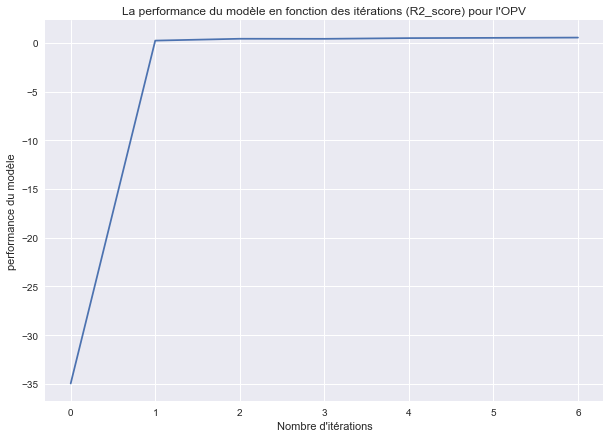

In [26]:
plt.figure(figsize = (10,7))
plt.title("La performance du modèle en fonction des itérations (R2_score) pour l'OPV")
plt.plot(np.arange(n_queries+1), score_model)
plt.xlabel("Nombre d'itérations")
plt.ylabel("performance du modèle")

In [ ]:
plt.figure(figsize = (10,7))
plt.title("L'erreur du modèle en fonction des itérations")
plt.plot(np.arange(n_queries+1), erreur_model)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Erreur du modèle")

## Prédire avec un jeu de test :

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)

In [ ]:
X_raw2=X_train.to_numpy()
Y_raw2=Y_train.to_numpy()

In [ ]:
racine2 = 0
n_initial2 = X_raw2.shape[0] 
size = 3
random.seed(racine2)
lab_indices2 =  random.sample(range(n_initial2), size)
print(lab_indices2)

In [ ]:
# Les données étiquetées.
X_lab2 = X_raw2[lab_indices2]
Y_lab2 = Y_raw2[lab_indices2] 

In [ ]:
# Les données non-étiquetées.
X_unlab2 = np.delete(X_raw2, lab_indices2, axis=0) 
Y_unlab2 = np.delete(Y_raw2, lab_indices2, axis=0)

In [ ]:
plt.scatter(X_lab2[:,1], Y_lab2, color = 'r', label="Données d'entraînement")
plt.scatter(X_unlab2[:,1], Y_unlab2, color='b', label="Données de pioche")
plt.legend(loc = "upper left")

In [ ]:
racine = 0
learner_list2 = [ActiveLearner(
                        estimator=RandomForestRegressor(random_state = idx+racine),
                        X_training=X_lab2, y_training=Y_lab2,
                )
                for idx in range(3)]

In [ ]:
# Le Committee
committee2 = CommitteeRegressor(
    learner_list=learner_list2,
    query_strategy=max_std_sampling
)

In [ ]:
# Prédiction de chaque apprenant
for learner_idx2, learner2 in enumerate(committee2):
    print('learner no %d : \n'  % (learner_idx2 + 1) , learner2.predict(X_raw2))

In [ ]:
# Isolate the data we'll need for plotting.
predictions_init2 = committee2.predict(X_raw2)

In [ ]:
err_init2 = mean_squared_error(predictions_init2, Y_raw2)
print(err_init2)

In [ ]:
score_init2 = r2_score(Y_raw2, predictions_init2)
print("score initial", score_init2)

In [ ]:
fig, ax = plt.subplots(1, 1, clear = True, num = 'Predicted vs Measured pce', figsize=(10, 6))  
prediction2 = committee2.predict(X_raw2)
for label, data in opv.groupby('exp'):   
    p1, = ax.plot(Y_raw2, predictions_init2, 'bo') 
    p2, = ax.plot(Y_lab2, predictions_init2[lab_indices2], 'ro')
plt.title('La première prediction du modèle')    
plt.plot([-1, 10], [-1, 10], ls = "--", c = ".3")  
plt.autoscale(enable = False)                    
plt.xlim(0,10)                             
plt.ylim(0,10)
plt.legend([p1,p2],["données du pool","données d'entraînement"], loc='upper left')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
font = {'size': 15}
ax.set_xlabel(r'Measured pce', font)
ax.set_ylabel(r'Predicted pce', font)

plt.style.use('seaborn')                 

plt.tight_layout()                        
plt.show()         

In [ ]:
#Active regression 
erreur_model2 = [err_init2]
score_model2 = [score_init2]
n_queries= 6
#performance_history = [unqueried_score]
# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(n_queries):
    query_index, query_instance = committee2.query(X_unlab2)
    print(query_index)
# Teach our ActiveLearner model the record it has requested.
    X_new, Y_new = X_unlab2[query_index].reshape(1, -1), Y_unlab2[query_index].reshape(1, )
    committee2.teach(X=X_new, y=Y_new)
    pred_new = committee2.predict(X_new)
    # Remove the queried instance from the unlabeled pool.
    X_lab2, Y_lab2= np.vstack([X_lab2, query_instance]), np.hstack([Y_lab2, Y_unlab2[query_index]])
    X_unlab2, Y_unlab2 = np.delete(X_unlab2, query_index, axis=0), np.delete(Y_unlab2, query_index)
    lab_indices2.extend(query_index)
    print(lab_indices2)
    predictions = committee2.predict(X_raw2)
    predictions_score = committee2.predict(X_test)
    #print(predictions)
    err = erreur(predictions, Y_raw2)
    erreur_model2.append(err)
    sc = r2_score(Y_test, predictions_score)
    score_model2.append(sc)
    plt.figure(figsize=(15, 15))
    plt.subplot(3,2,index+1)
    for label, data in opv.groupby('exp'): 
        p1, = plt.plot(Y_raw2, predictions, 'ko')
        #plt.plot(Y_unlab[query_index], )
        p2, = plt.plot(Y_lab2, predictions[lab_indices2], 'ro')
        p3, = plt.plot(Y_new, pred_new, 'go')
        plt.title('iteration no %d' % (index+1))    
    plt.plot([-1, 10], [-1, 10], ls = "--", c = ".3")  
    plt.autoscale(enable = False)                    
    plt.legend([p1,p2,p3],["le pool","données d'entraînement","données rajoutées"], loc='upper left')
    plt.xlim(0,10)                             
    plt.ylim(0,10)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    font = {'size': 15}
    plt.xlabel('PCE mesuré', font)
    plt.ylabel('PCE prédit', font)

In [ ]:
fig, ax1 = plt.subplots(1, 1, clear = True, num = 'Predicted vs Measured pce', figsize=(7, 7))  
prediction = committee2.predict(X_raw2)
for label, data in opv.groupby('exp'):   
    plt.plot(Y_raw2, prediction, 'o') 
plt.title('Committee predictions finals après %d queries' % n_queries)
plt.legend(loc='lower right', frameon = True)     
plt.plot([-1, 10], [-1, 10], ls = "--", c = ".3")  
plt.autoscale(enable = False)                    
plt.xlim(0,10)                             
plt.ylim(0,10)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
font = {'size': 15}
ax1.set_xlabel(r'Measured pce', font)
ax1.set_ylabel(r'Predicted pce', font)

plt.style.use('seaborn')                 

plt.tight_layout()                        
plt.show() 

In [ ]:
plt.figure(figsize = (10,7))
plt.title("Performance du modèle sur le jeu de test en fonction des itérations")
plt.plot(np.arange(n_queries+1), score_model2)
plt.xlabel("Nombre d'itérations")
plt.ylabel("performance du modèle")

In [ ]:
plt.figure(figsize = (10,7))
plt.title("L'erreur du modèle sur le jeu de test en fonction des itérations")
plt.plot(np.arange(n_queries+1), erreur_model2)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Erreur du modèle")

In [ ]:
pred_f = committee2.predict(X_test)

In [ ]:
err_f = mean_squared_error(pred_f, Y_test)
print("erreur du modèle sur un nouveau jeu de données", err_f)